In [1]:
import faro
import faro.proto.proto_types as pt

In [2]:
class FaroOptions(object):
    def __init__(self):
        self.detect_port = faro.DEFAULT_PORT
        self.rec_port = faro.DEFAULT_PORT
options = FaroOptions()
client = faro.FaceClient(options)

<bound method FaceClient.status of <faro.FaceClient.FaceClient object at 0x1245409b0>>


This next command will contact the service and return some basic information about the currently running service.  If successful this should return a "status: READY" message.

In [3]:
status = client.status()[1]
status

status: READY
detection_support: true
extract_support: true
score_support: true
score_type: L2
match_threshold: 0.6000000238418579
algorithm: "DLIB_19.17.0"

Now use pyvision to load an image.

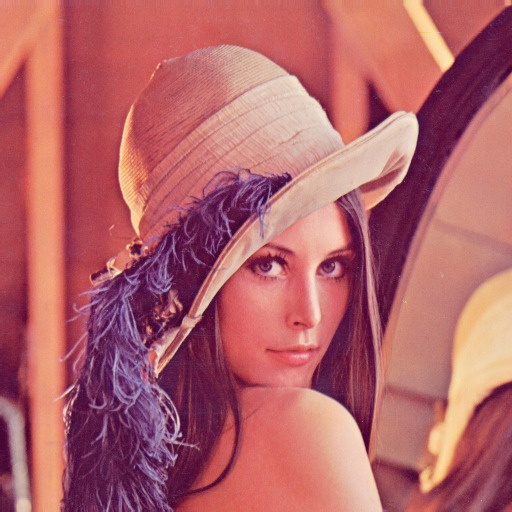

In [4]:
import pyvision as pv
lena = pv.Image(pv.LENA)
lena.show()

In [5]:
faces = client.detect(lena)
# This should also print a log message on the server display.
faces

face_records {
  detection {
    score: 0.9629286527633667
    location {
      x: 218.0
      y: 219.0
      width: 156.0
      height: 156.0
    }
    detection_class: "FACE_2"
  }
}

In [6]:
faces

face_records {
  detection {
    score: 0.9629286527633667
    location {
      x: 218.0
      y: 219.0
      width: 156.0
      height: 156.0
    }
    detection_class: "FACE_2"
  }
}

In [7]:
# Prototypes offers converters for common datastructures.  This one converts from a protobuf to a pyvision (pv) rect.
rect = pt.rect_proto2pv(faces.face_records[0].detection.location)
rect

pv.Rect(218.000000,219.000000,156.000000,156.000000)

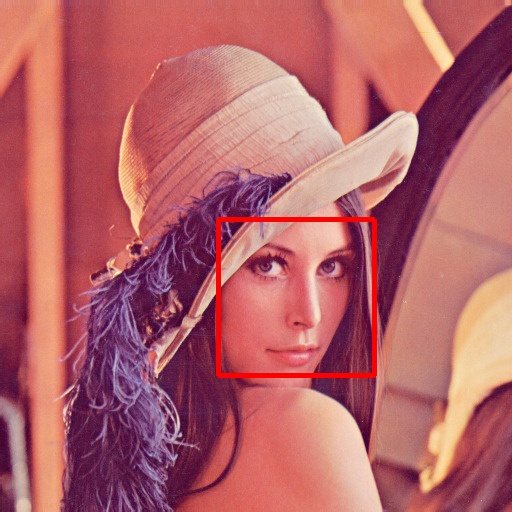

In [8]:
lena.annotateThickRect(rect)
lena.show()

Now lets try the same thing but with the mirrored image.

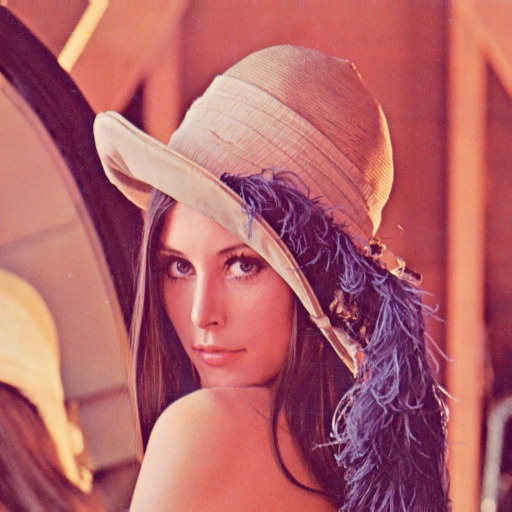

In [9]:
cvim = lena.asOpenCV2()[:,::-1,:]
lena_mirror = pv.Image(cvim)
#lena_mirror = pv.AffineScale(0.99,lena.size)(lena_mirror)
lena_mirror.show()

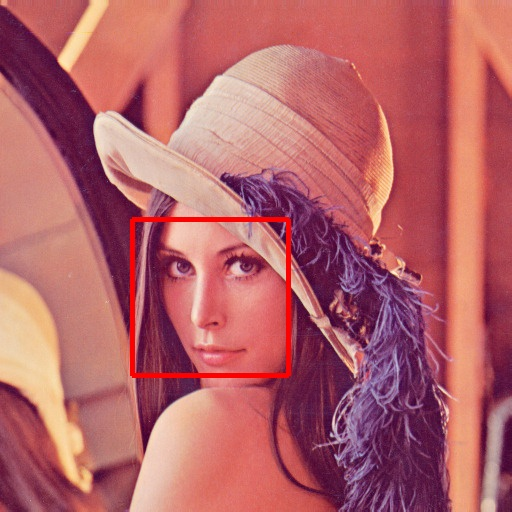

In [10]:
faces_mirror = client.detect(lena_mirror)
rect_mirror = pt.rect_proto2pv(faces_mirror.face_records[0].detection.location)
lena_mirror.annotateThickRect(rect_mirror)
lena_mirror.show()

In [11]:
faces = client.extract(lena,faces)
faces_mirror = client.extract(lena_mirror,faces)

In [12]:
# Here we can decode the template and view it as a vector.
pt.vector_proto2np( faces.face_records[0].template.data )

array([-4.45432328e-02,  1.19129203e-01,  1.07368052e-01, -1.24593772e-01,
       -1.93349183e-01,  3.08535676e-02, -1.10984243e-01, -9.53230262e-02,
        2.11410314e-01, -1.04715966e-01,  1.73750997e-01, -4.97710630e-02,
       -2.66305417e-01,  1.08654357e-01, -8.41444954e-02,  1.60673752e-01,
       -1.90567538e-01, -1.33025602e-01, -9.93257985e-02, -1.12809695e-01,
       -2.35246681e-02,  1.55630693e-01,  5.04182167e-02,  3.39534357e-02,
       -1.08716011e-01, -3.40711892e-01, -2.79314909e-02, -8.78840461e-02,
        3.91207896e-02, -9.93028432e-02,  7.11900964e-02,  9.12593231e-02,
       -1.54419646e-01,  3.09166312e-02,  6.66256025e-02,  1.19853534e-01,
       -7.05400063e-03, -1.53041050e-01,  7.81121925e-02, -3.29705738e-02,
       -2.16924667e-01, -1.04478359e-01,  1.02034591e-01,  1.97095901e-01,
        1.63225368e-01, -5.54133430e-02,  7.85388574e-02, -1.31455749e-01,
        1.39565676e-01, -2.90237099e-01,  4.42963056e-02,  9.74046886e-02,
        1.86469462e-02,  

Now we compare the to face templates.


In [13]:
all_rec = list(faces.face_records) + list( faces_mirror.face_records)

scores = client.score(faces.face_records,faces_mirror.face_records)

scores

array([[0.59750086]], dtype=float32)

Now check if it is a match.

In [14]:
print('Score:',scores[0,0],' Thresh:',status.match_threshold)
if scores[0,0] < status.match_threshold:
    print("The faces MATCH.")
else:
    print("The faces DO NOT MATCH.")

Score: 0.59750086  Thresh: 0.6000000238418579
The faces MATCH.


The lena and lena_mirror images typically produce scores near the 0.6 threshold.  The dlib introduces random perturbations to the images so sometimes the faces match and sometimes they don't.  Most other algorithms are determinisitic and will produce the same value each time.